In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
import keras.callbacks as kcallbacks
import keras
from keras.preprocessing.image import load_img,img_to_array
import math
import random

Using TensorFlow backend.


In [2]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

# vgg19模型 -without transfer learning

In [3]:
#创建一个实例来存储history
vgg_history_without= LossHistory()

In [4]:
###########配置的文件####################
TARGET_SIZE=(512,512)
INPUT_SIZE=(512,512,3)
BATCHSIZE=16
##################################
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

print('样本0的数量是%s'%len(os.listdir('./train/0')))
print('样本1的数量是%s'%len(os.listdir('./train/1')))
print('样本2的数量是%s'%len(os.listdir('./train/2')))
print('样本3的数量是%s'%len(os.listdir('./train/3')))
print('样本4的数量是%s'%len(os.listdir('./train/4')))
def vgg19net(input_shape,num_class,epochs,savepath='./vgg_model_without.h5'):
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,2),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=1500,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=math.ceil(10000/BATCHSIZE),
        callbacks=[earlyStopping,saveBestModel,vgg_history_without]
    )
    with open('vgg_without_log.txt','w') as f:
        f.write(str(hist.history))

Found 49658 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.
样本0的数量是21534
样本1的数量是7891
样本2的数量是9752
样本3的数量是5644
样本4的数量是4837


In [5]:
vgg_model=vgg19net(INPUT_SIZE,num_class=5,epochs=20)

Epoch 1/20
1500/1500 [==============================] - 1325s 883ms/step - loss: 1.4680 - acc: 0.4282 - val_loss: 1.4632 - val_acc: 0.4276
Epoch 2/20
1500/1500 [==============================] - 1319s 879ms/step - loss: 1.4457 - acc: 0.4395 - val_loss: 1.4515 - val_acc: 0.4276
Epoch 3/20
1500/1500 [==============================] - 1319s 880ms/step - loss: 1.4516 - acc: 0.4311 - val_loss: 1.4566 - val_acc: 0.4276
Epoch 4/20
1500/1500 [==============================] - 1319s 879ms/step - loss: 1.4495 - acc: 0.4352 - val_loss: 1.4518 - val_acc: 0.4276
Epoch 5/20
1500/1500 [==============================] - 1319s 879ms/step - loss: 1.4518 - acc: 0.4334 - val_loss: 1.4574 - val_acc: 0.4276
Epoch 6/20
1500/1500 [==============================] - 1319s 879ms/step - loss: 1.4491 - acc: 0.4340 - val_loss: 1.4557 - val_acc: 0.4276
Epoch 00006: early stopping


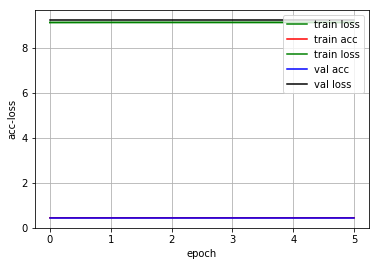

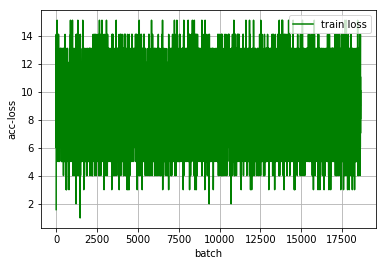

In [13]:
import matplotlib.pyplot as plt
import pickle
to_save={}
to_save['losses']=vgg_history_without.losses
to_save['accuracy']=vgg_history_without.accuracy
to_save['val_loss']=vgg_history_without.val_loss
to_save['val_acc']=vgg_history_without.val_acc
with open('vgg_history_without.pickle','wb') as f:
    pickle.dump(to_save,f)
vgg_history_without.loss_plot('epoch')
vgg_history_without.loss_plot('batch')
plt.show()

# VGG19 fine-tune

In [3]:
#创建一个实例来存储history
vgg_history_finetune= LossHistory()

In [4]:
###########配置的文件####################
TARGET_SIZE=(512,512)
INPUT_SIZE=(512,512,3)
BATCHSIZE=16
##################################
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

print('样本0的数量是%s'%len(os.listdir('./train/0')))
print('样本1的数量是%s'%len(os.listdir('./train/1')))
print('样本2的数量是%s'%len(os.listdir('./train/2')))
print('样本3的数量是%s'%len(os.listdir('./train/3')))
print('样本4的数量是%s'%len(os.listdir('./train/4')))
def vgg19net(input_shape,num_class,epochs,savepath='./vgg_model.h5'):
    model_vgg19=VGG19(include_top=False,weights='imagenet',input_shape=input_shape)
#     # 冻结所有的训练好的层
    for layer in model_vgg19.layers[:16]:  
        layer.trainable = False  
    for layer in model_vgg19.layers[16:]:  
        layer.trainable = True  
    # 平均池化之后接全连接层
    model= GlobalAveragePooling2D()(model_vgg19.output)  
    model=Dense(256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model=Dense(128,activation='relu')(model)
    model=Dropout(0.5)(model)
    model=Dense(num_class,activation='softmax')(model)
    model_vgg19_clair=Model(model_vgg19.input,model,name='vgg19')
    #定义一下优化的方法
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    #compile一下模型
    model_vgg19_clair.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#     model_vgg19_clair.fit(X_train_vgg,y_train,batch_size=batchsize,epochs=epochs,verbose=1,
#               validation_data=(X_test_vgg,y_test),shuffle=True,callbacks=[earlyStopping,saveBestModel])
    hist=model_vgg19_clair.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(49658/BATCHSIZE),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=math.ceil(10000/BATCHSIZE),
        callbacks=[earlyStopping,saveBestModel,vgg_history_finetune]
    )
    with open('vgg_finetune_log.txt','w') as f:
        f.write(str(hist.history))

Found 49658 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.
样本0的数量是21534
样本1的数量是7891
样本2的数量是9752
样本3的数量是5644
样本4的数量是4837


In [5]:
vgg_model=vgg19net(INPUT_SIZE,num_class=5,epochs=20)

Epoch 1/20
3104/3104 [==============================] - 1164s 375ms/step - loss: 1.1443 - acc: 0.5499 - val_loss: 1.0492 - val_acc: 0.5825
Epoch 2/20
3104/3104 [==============================] - 1163s 375ms/step - loss: 0.9975 - acc: 0.6128 - val_loss: 0.9597 - val_acc: 0.6244
Epoch 3/20
3104/3104 [==============================] - 1166s 376ms/step - loss: 0.9538 - acc: 0.6308 - val_loss: 0.9457 - val_acc: 0.6230
Epoch 4/20
3104/3104 [==============================] - 1164s 375ms/step - loss: 0.9381 - acc: 0.6396 - val_loss: 0.9156 - val_acc: 0.6344
Epoch 5/20
3104/3104 [==============================] - 1162s 374ms/step - loss: 0.9161 - acc: 0.6467 - val_loss: 0.9318 - val_acc: 0.6336
Epoch 6/20
3104/3104 [==============================] - 1163s 375ms/step - loss: 0.9027 - acc: 0.6508 - val_loss: 0.9185 - val_acc: 0.6374
Epoch 7/20
3104/3104 [==============================] - 1163s 375ms/step - loss: 0.8919 - acc: 0.6535 - val_loss: 0.9622 - val_acc: 0.6165
Epoch 8/20
3104/3104 [=====

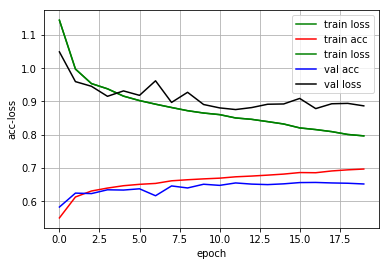

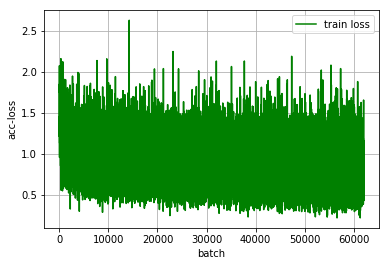

In [6]:
import matplotlib.pyplot as plt
import pickle
to_save={}
to_save['losses']=vgg_history_finetune.losses
to_save['accuracy']=vgg_history_finetune.accuracy
to_save['val_loss']=vgg_history_finetune.val_loss
to_save['val_acc']=vgg_history_finetune.val_acc
with open('vgg_finetune_history.pickle','wb') as f:
    pickle.dump(to_save,f)
vgg_history_finetune.loss_plot('epoch')
vgg_history_finetune.loss_plot('batch')
plt.show()

# inceptionv3模型

In [3]:
#创建一个实例来存储history
inception_history = LossHistory()

In [4]:
###########配置的文件####################
TARGET_SIZE=(512,512)
INPUT_SIZE=(512,512,3)
BATCHSIZE=64
##################################
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

print('样本0的数量是%s'%len(os.listdir('./train/0')))
print('样本1的数量是%s'%len(os.listdir('./train/1')))
print('样本2的数量是%s'%len(os.listdir('./train/2')))
print('样本3的数量是%s'%len(os.listdir('./train/3')))
print('样本4的数量是%s'%len(os.listdir('./train/4')))
def inception(input_shape,num_class,epochs,savepath='./inception.h5'):
    model_inc=InceptionV3(include_top=False,weights='imagenet',input_shape=input_shape)
    # 冻结部分的层
    for layer in model_inc.layers[:200]:  
        layer.trainable = False 
    for layer in model_inc.layers[200:]:  
        layer.trainable = True  
    # 平均池化之后接全连接层
    model= GlobalAveragePooling2D()(model_inc.output)  
    model=Dense(128,activation='relu')(model)
    model=Dense(num_class,activation='softmax')(model)
    model_inc=Model(model_inc.input,model,name='inception')
    #定义一下优化的方法
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    #compile一下模型
    model_inc.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#     model_vgg19_clair.fit(X_train_vgg,y_train,batch_size=batchsize,epochs=epochs,verbose=1,
#               validation_data=(X_test_vgg,y_test),shuffle=True,callbacks=[earlyStopping,saveBestModel])
    hist=model_inc.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(49658/BATCHSIZE),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=math.ceil(10000/BATCHSIZE),
        callbacks=[earlyStopping,saveBestModel,inception_history],
        workers=8
    )
    with open('inc_log.txt','w') as f:
        f.write(str(hist.history))

Found 49658 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.
样本0的数量是21534
样本1的数量是7891
样本2的数量是9752
样本3的数量是5644
样本4的数量是4837


In [5]:
inception=inception(INPUT_SIZE,num_class=5,epochs=30)

Epoch 1/30
776/776 [==============================] - 849s 1s/step - loss: 0.8230 - acc: 0.6796 - val_loss: 0.7254 - val_acc: 0.7176
Epoch 2/30
776/776 [==============================] - 836s 1s/step - loss: 0.6832 - acc: 0.7384 - val_loss: 0.7331 - val_acc: 0.7206
Epoch 3/30
776/776 [==============================] - 837s 1s/step - loss: 0.5972 - acc: 0.7719 - val_loss: 0.6504 - val_acc: 0.7537
Epoch 4/30
776/776 [==============================] - 836s 1s/step - loss: 0.5050 - acc: 0.8091 - val_loss: 0.6877 - val_acc: 0.7409
Epoch 5/30
776/776 [==============================] - 836s 1s/step - loss: 0.4182 - acc: 0.8449 - val_loss: 0.8061 - val_acc: 0.7566
Epoch 6/30
776/776 [==============================] - 836s 1s/step - loss: 0.3334 - acc: 0.8772 - val_loss: 0.7953 - val_acc: 0.7478
Epoch 7/30
776/776 [==============================] - 836s 1s/step - loss: 0.2592 - acc: 0.9044 - val_loss: 0.8482 - val_acc: 0.7615
Epoch 8/30
776/776 [==============================] - 836s 1s/step - 

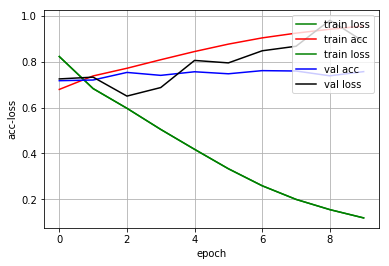

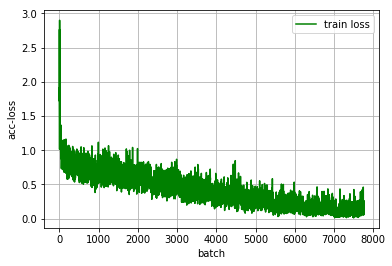

In [6]:
import matplotlib.pyplot as plt
import pickle
to_save={}
to_save['losses']=inception_history.losses
to_save['accuracy']=inception_history.accuracy
to_save['val_loss']=inception_history.val_loss
to_save['val_acc']=inception_history.val_acc
with open('inception_log.pickle','wb') as f:
    pickle.dump(to_save,f)
inception_history.loss_plot('epoch')
inception_history.loss_plot('batch')
plt.show()

# Retnet-50

In [9]:
#创建一个实例来存储history
resnet_history= LossHistory()

In [10]:
model_res=ResNet50(include_top=False,weights='imagenet')
model_res.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [11]:
for i, layer in enumerate(model_res.layers):
    print(i, model_res.name)

0 resnet50
1 resnet50
2 resnet50
3 resnet50
4 resnet50
5 resnet50
6 resnet50
7 resnet50
8 resnet50
9 resnet50
10 resnet50
11 resnet50
12 resnet50
13 resnet50
14 resnet50
15 resnet50
16 resnet50
17 resnet50
18 resnet50
19 resnet50
20 resnet50
21 resnet50
22 resnet50
23 resnet50
24 resnet50
25 resnet50
26 resnet50
27 resnet50
28 resnet50
29 resnet50
30 resnet50
31 resnet50
32 resnet50
33 resnet50
34 resnet50
35 resnet50
36 resnet50
37 resnet50
38 resnet50
39 resnet50
40 resnet50
41 resnet50
42 resnet50
43 resnet50
44 resnet50
45 resnet50
46 resnet50
47 resnet50
48 resnet50
49 resnet50
50 resnet50
51 resnet50
52 resnet50
53 resnet50
54 resnet50
55 resnet50
56 resnet50
57 resnet50
58 resnet50
59 resnet50
60 resnet50
61 resnet50
62 resnet50
63 resnet50
64 resnet50
65 resnet50
66 resnet50
67 resnet50
68 resnet50
69 resnet50
70 resnet50
71 resnet50
72 resnet50
73 resnet50
74 resnet50
75 resnet50
76 resnet50
77 resnet50
78 resnet50
79 resnet50
80 resnet50
81 resnet50
82 resnet50
83 resnet50
84

In [12]:
###########配置的文件####################
TARGET_SIZE=(512,512)
INPUT_SIZE=(512,512,3)
BATCHSIZE=64
##################################
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
print('样本0的数量是%s'%len(os.listdir('./train/0')))
print('样本1的数量是%s'%len(os.listdir('./train/1')))
print('样本2的数量是%s'%len(os.listdir('./train/2')))
print('样本3的数量是%s'%len(os.listdir('./train/3')))
print('样本4的数量是%s'%len(os.listdir('./train/4')))
def resnet(input_shape,num_class,epochs,savepath='./resnet.h5'):
    model_res=ResNet50(include_top=False,weights='imagenet')
    # 平均池化之后接全连接层
    model= GlobalAveragePooling2D()(model_res.output)  
    model=Dense(128,activation='relu')(model)
    model=Dense(num_class,activation='softmax')(model)
    model_res_clair=Model(model_res.input,model,name='resnet')
    #定义一下优化的方法
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # fine-tune
    for layer in model_res.layers[:135]:  
        layer.trainable = False 
    for layer in model_res.layers[135:]:  
        layer.trainable = True  
    #compile一下模型
    model_res_clair.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#     model_vgg19_clair.fit(X_train_vgg,y_train,batch_size=batchsize,epochs=epochs,verbose=1,
#               validation_data=(X_test_vgg,y_test),shuffle=True,callbacks=[earlyStopping,saveBestModel])
    hist=model_res_clair.fit_generator(
        train_generator,
        steps_per_epoch=math.ceil(49658/BATCHSIZE),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=math.ceil(10000/BATCHSIZE),
        callbacks=[earlyStopping,saveBestModel,resnet_history]
    )
    with open('res_net_log.txt','w') as f:
        f.write(str(hist.history))

Found 49658 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.
样本0的数量是21534
样本1的数量是7891
样本2的数量是9752
样本3的数量是5644
样本4的数量是4837


In [13]:
res_model=resnet(INPUT_SIZE,num_class=5,epochs=20)

Epoch 1/20
776/776 [==============================] - 998s 1s/step - loss: 0.8132 - acc: 0.6844 - val_loss: 2.0037 - val_acc: 0.4293
Epoch 2/20
776/776 [==============================] - 991s 1s/step - loss: 0.6896 - acc: 0.7330 - val_loss: 0.7116 - val_acc: 0.7274
Epoch 3/20
776/776 [==============================] - 991s 1s/step - loss: 0.5957 - acc: 0.7737 - val_loss: 0.7651 - val_acc: 0.7220
Epoch 4/20
776/776 [==============================] - 991s 1s/step - loss: 0.4835 - acc: 0.8194 - val_loss: 0.7761 - val_acc: 0.7350
Epoch 5/20
776/776 [==============================] - 991s 1s/step - loss: 0.3560 - acc: 0.8696 - val_loss: 0.8536 - val_acc: 0.6993
Epoch 6/20
776/776 [==============================] - 991s 1s/step - loss: 0.2302 - acc: 0.9177 - val_loss: 0.8266 - val_acc: 0.7444
Epoch 7/20
776/776 [==============================] - 991s 1s/step - loss: 0.1471 - acc: 0.9481 - val_loss: 1.1897 - val_acc: 0.7529
Epoch 8/20
776/776 [==============================] - 991s 1s/step - 

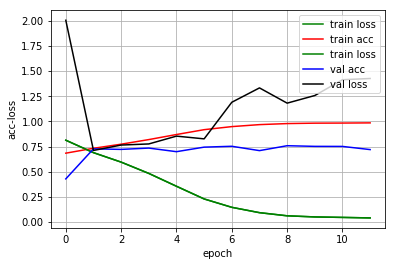

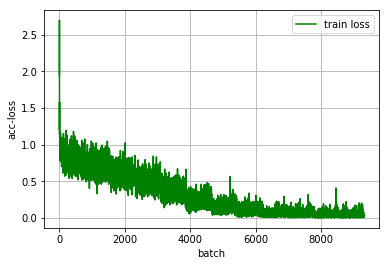

In [14]:
import matplotlib.pyplot as plt
import pickle
to_save={}
to_save['losses']=resnet_history.losses
to_save['accuracy']=resnet_history.accuracy
to_save['val_loss']=resnet_history.val_loss
to_save['val_acc']=resnet_history.val_acc
with open('res_log.pickle','wb') as f:
    pickle.dump(to_save,f)
resnet_history.loss_plot('epoch')
resnet_history.loss_plot('batch')
plt.show()